In [1]:
# loading essential libraries first
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt



Matplotlib is building the font cache; this may take a moment.


In [2]:
# data
mdata = sm.datasets.macrodata.load_pandas().data
df  = mdata.iloc[:, 2:4]
df.head()

# import for Granger's Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
granger_test = sm.tsa.stattools.grangercausalitytests(df, maxlag=2, verbose=True)
granger_test

nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")
#apply adf test on the series
adf_test(df_train["realgdp"])
adf_test(df_train["realcons"])

# 1st difference
df_differenced = df_train.diff().dropna()
# stationarity test again with differenced data
adf_test(df_differenced["realgdp"])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1851  , p=0.6675  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=0.1879  , p=0.6646  , df=1
likelihood ratio test: chi2=0.1878  , p=0.6647  , df=1
parameter F test:         F=0.1851  , p=0.6675  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=22.9218 , p=0.0000  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=47.0132 , p=0.0000  , df=2
likelihood ratio test: chi2=42.2456 , p=0.0000  , df=2
parameter F test:         F=22.9218 , p=0.0000  , df_denom=196, df_num=2
Test Statistic            1.915476
p-value                   0.998553
# Lags                    2.000000
# Observations          196.000000
Critical Value (1%)      -3.464161
Critical Value (5%)      -2.876402
Critical Value (10%)     -2.574692
dtype: float64
 Series is Non-Stationary
Test Statistic            0.755577
p-value                   0.990884
# Lags                    3.000000
# Obs

In [3]:
# model fitting
model = VAR(df_differenced)
results = model.fit(maxlags=15, ic='aic')
results.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 15, Dec, 2020
Time:                     16:49:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.2225
Nobs:                     195.000    HQIC:                   14.0826
Log likelihood:          -1903.17    FPE:                1.18772e+06
AIC:                      13.9875    Det(Omega_mle):     1.10683e+06
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              10.539111         6.135458            1.718           0.086
L1.realgdp         -0.135636         0.085377           -1.589           0.112
L1.realcons         0.821284         0.139260            5.897    

In [4]:
# forecasting
lag_order = results.k_ar
results.forecast(df.values[-lag_order:], 5)

array([[10290.5747705 ,  6613.2380308 ],
       [ 8517.53900903,  6003.61472148],
       [ 7019.68760716,  5249.17897406],
       [ 6137.23354248,  4201.22699968],
       [ 5146.61872133,  3726.24493242]])

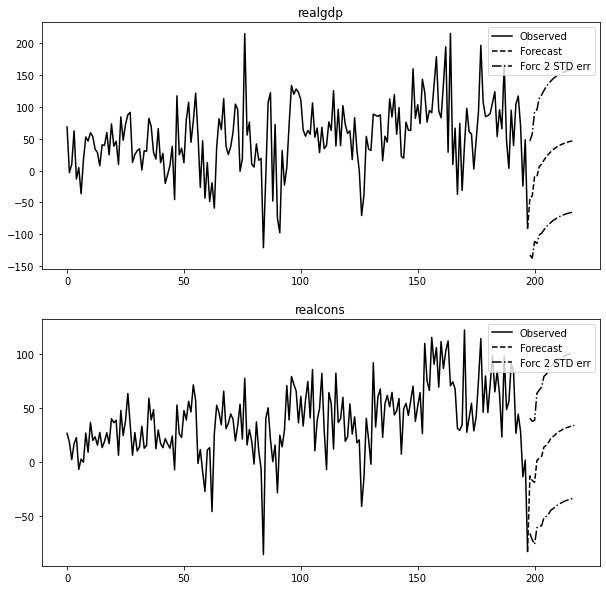

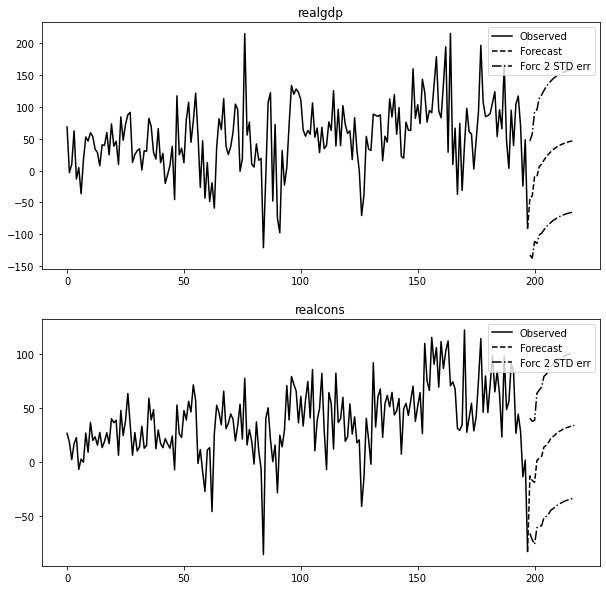

In [5]:
# plotting
results.plot_forecast(20)

In [6]:
# Evaluation
fevd = results.fevd(5)
fevd.summary()

FEVD for realgdp
      realgdp  realcons
0    1.000000  0.000000
1    0.855210  0.144790
2    0.806136  0.193864
3    0.762372  0.237628
4    0.732677  0.267323

FEVD for realcons
      realgdp  realcons
0    0.284790  0.715210
1    0.273130  0.726870
2    0.261571  0.738429
3    0.224091  0.775909
4    0.219314  0.780686




In [7]:
# forecasting
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast.tail()
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['realgdp_forecast', 'realcons_forecast']]

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,realgdp_forecast,realcons_forecast
199,13190.828174,9171.244529
200,13017.091744,9057.303996
201,12834.042004,8924.194948
202,12641.596233,8792.278617
